In [ ]:
%load_ext autoreload
%autoreload 2

In [42]:
import pandas as pd
import numpy as np
import csrar
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [54]:
data = pd.read_csv('../data/Injector_Median100k.csv')

In [60]:
X = data.drop('Col174', axis=1)
y = data['Col174']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [38]:
X_test

,Col0,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,...,Col164,Col165,Col166,Col167,Col168,Col169,Col170,Col171,Col172,Col173
93155,157.3,-2.5,154.8,0.000000,36.2,186.8,237.2,217.2,1016,20.29,...,0.00,0.000000,5,61.608887,61.132812,77.514648,72.180176,72.167969,0.260,105.06
65641,36.7,0.2,36.9,0.000000,8.6,37.8,46.6,45.4,995,18.94,...,0.00,0.000000,1,80.004883,80.004883,74.121094,80.004883,80.004883,-0.043,3.87
19149,80.0,1.4,81.4,0.000000,26.3,81.3,113.7,107.5,981,24.41,...,0.00,0.000000,4,70.031738,70.031738,70.446777,76.013184,76.013184,-0.043,49.50
45549,80.1,1.4,81.5,18.615723,48.4,84.1,143.3,130.0,982,37.54,...,0.00,0.000000,7,80.004883,80.004883,73.522949,80.004883,80.004883,0.000,103.62
86702,50.7,-0.5,50.2,0.000000,20.3,53.2,78.6,74.1,1004,31.98,...,0.03,0.000000,1,80.004883,80.004883,71.362305,80.004883,80.004883,0.043,9.87
47098,277.5,0.5,278.0,0.000000,72.9,285.8,380.6,350.9,1166,20.34,...,0.00,0.000000,7,80.004883,80.004883,77.514648,52.392578,51.855469,-0.043,147.68
91703,43.3,-0.3,43.0,0.000000,1.4,44.7,44.1,44.2,991,3.27,...,94.94,95.104980,5,76.953125,76.953125,70.898438,78.784180,78.784180,-0.434,50.12
82987,89.8,0.4,90.3,24.108887,37.1,104.6,134.3,124.3,1002,26.43,...,0.07,0.000000,3,80.004883,80.004883,77.819824,80.004883,80.004883,0.652,53.12
99465,342.7,-12.7,330.0,47.607422,-6.5,347.5,323.2,323.3,1208,0.00,...,0.00,0.000000,7,41.223145,41.223145,70.129395,0.000000,0.000000,-0.130,169.56
46319,177.1,1.2,178.4,34.790039,65.9,188.5,278.7,253.0,1043,27.90,...,0.00,0.000000,7,80.004883,80.004883,77.819824,79.919434,79.919434,0.086,119.31


In [34]:
a = set(X_test.index)
np.unique([i in a for i in X_train.index])

array([False], dtype=bool)

In [ ]:
X_test

In [3]:
rar_data = pd.concat([X_train, y_train], axis=1)

In [ ]:
rar_data

In [4]:
target = 'Col174'
rar = csrar.rar.RaR(rar_data)


In [5]:
rar.run(target, k=5, runs=200)

1. Col91
2. Col44
3. Col107
4. Col31
5. Col104
6. Col123
7. Col90
8. Col112
9. Col113
10. Col29
11. Col121
12. Col39
13. Col117
14. Col130
15. Col128
16. Col80
17. Col103
18. Col116
19. Col120
20. Col81
21. Col32
22. Col67
23. Col93
24. Col111
25. Col118
26. Col92
27. Col15
28. Col57
29. Col124
30. Col30
31. Col119
32. Col106
33. Col105
34. Col127
35. Col61
36. Col122
37. Col125
38. Col133
39. Col169
40. Col88
41. Col163
42. Col96
43. Col69
44. Col75
45. Col41
46. Col160
47. Col148
48. Col142
49. Col10
50. Col37
51. Col126
52. Col35
53. Col66
54. Col36
55. Col150
56. Col62
57. Col79
58. Col33
59. Col4
60. Col38
61. Col156
62. Col95
63. Col97
64. Col98
65. Col109
66. Col55
67. Col78
68. Col0
69. Col135
70. Col42
71. Col7
72. Col22
73. Col100
74. Col89
75. Col76
76. Col147
77. Col168
78. Col26
79. Col141
80. Col65
81. Col153
82. Col157
83. Col131
84. Col51
85. Col11
86. Col102
87. Col71
88. Col144
89. Col94
90. Col34
91. Col70
92. Col2
93. Col161
94. Col108
95. Col99
96. Col20
97. Col25


In [11]:
selected_features = list(map(lambda r: r[0], rar.feature_ranking[:15]))

In [14]:
X_train_s = X_train[selected_features]

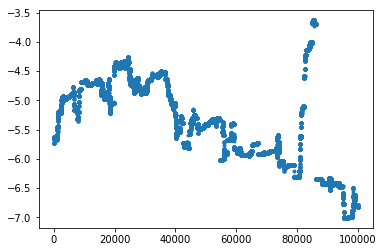

In [90]:
import matplotlib.pyplot as plt
plt.plot(X_train['Col132'], linestyle='', marker='.')
plt.show()

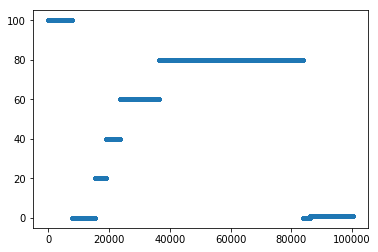

In [91]:
plt.plot(y_train, linestyle='', marker='.')
plt.show()

In [68]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.99992515530274684

In [85]:
from sklearn import tree
import pydot
from sklearn.externals.six import StringIO
dot_data = StringIO()
tree.export_graphviz(clf, out_file='tree.dot') 
# graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
# graph[0].write_pdf("tree.pdf") 

In [50]:
for index, p in enumerate(clf.predict(X_test)):
    print('{}. {}'.format(index+1, p))

1. 80
2. 1
3. 100
4. 100
5. 80
6. 1
7. 0
8. 0
9. 60
10. 60
11. 1
12. 60
13. 80
14. 60
15. 80
16. 80
17. 80
18. 1
19. 80
20. 40
21. 80
22. 40
23. 100
24. 80
25. 80
26. 80
27. 60
28. 60
29. 60
30. 80
31. 80
32. 60
33. 80
34. 80
35. 60
36. 80
37. 80
38. 60
39. 40
40. 1
41. 80
42. 80
43. 60
44. 80
45. 20
46. 0
47. 80
48. 1
49. 80
50. 80
51. 0
52. 1
53. 0
54. 60
55. 80
56. 80
57. 80
58. 40
59. 80
60. 0
61. 80
62. 40
63. 80
64. 80
65. 0
66. 80
67. 80
68. 80
69. 20
70. 80
71. 60
72. 60
73. 80
74. 80
75. 80
76. 60
77. 80
78. 80
79. 0
80. 0
81. 1
82. 80
83. 80
84. 80
85. 1
86. 0
87. 60
88. 60
89. 100
90. 60
91. 80
92. 100
93. 80
94. 60
95. 1
96. 80
97. 0
98. 1
99. 80
100. 40
101. 1
102. 80
103. 1
104. 40
105. 20
106. 100
107. 100
108. 80
109. 80
110. 80
111. 80
112. 0
113. 100
114. 40
115. 1
116. 1
117. 0
118. 60
119. 80
120. 80
121. 80
122. 60
123. 0
124. 80
125. 100
126. 80
127. 20
128. 80
129. 40
130. 0
131. 1
132. 40
133. 1
134. 60
135. 80
136. 1
137. 20
138. 80
139. 80
140. 80
141. 60
142.

In [51]:
y_test

75754     80
91944      1
256      100
6652     100
40424     80
99367      1
10741      0
12802      0
34672     60
28155     60
95801      1
31604     60
58975     80
31644     60
56195     80
74087     80
82708     80
90671      1
75706     80
22509     40
72959     80
22755     40
6390     100
46819     80
79520     80
52891     80
24677     60
25178     60
34799     60
37423     80
        ... 
13507      0
30618     60
86316      1
86213      1
4536     100
5548     100
58684     80
40180     80
40720     80
35737     60
89060      1
40031     80
37486     80
64934     80
13159      0
60575     80
66367     80
19388     40
94116      1
75426     80
85446      0
72904     80
87935      1
3503     100
94467      1
69447     80
78516     80
62485     80
85609      0
27447     60
Name: Col174, Length: 40083, dtype: int64

In [61]:
clf_selected = RandomForestClassifier()
clf_selected.fit(X_train_s, y_train)
clf_selected.score(X_test, y_test)

1.0

In [ ]:
ranking = []
for index, importance in enumerate(clf.feature_importances_):
    ranking.append((data.columns[index], importance))
ranking.sort(key=lambda r: r[1], reverse=True)
for (index, rank) in enumerate(ranking):
        print('{}. {} with a score of {}'.format(index + 1, rank[0], rank[1]))